# Molecular Weight Binning Preprocessor

This notebook outlines the creation of a preprocessor that bins molecular weights. The binning is done using the sklearn KBinsDiscretizer and can use one of three strategies
1. quantile (default)
2. uniform
3. kmeans

The default, quantile, attempts to get uniform distribution of items into bins. The bin widths will not be uniform, but are varied to equalize number of elements. Uniform uses an evenly spaced binning. Kmeans uses kmeans to determine the bin edges.

In [1]:
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from polyid.preprocessors import PolymerPreprocessor
import networkx as nx
from typing import Dict
import tensorflow as tf

from polyid.polyid import MultiModel

# Preprocessor Code

In [2]:
class WeightDiscPreprocessor(PolymerPreprocessor):
    """preprocesses using a Mw and Mn column and binning it. Uses KBinsDiscretizer and accepts encoding and strategy args."""

    def __init__(
        self,
        n_bins: int = 20,
        encode="ordinal",
        strategy="quantile",
        **kwargs,
    ):
        super(PolymerPreprocessor, self).__init__(**kwargs)
        self.n_bins = n_bins
        
        self.train = True
        self.training_mn = []
        self.training_mw = []
        
        # Track whether or not to refit
        self._new_since_trained = False
        self.mn_kbd = KBinsDiscretizer(n_bins=self.n_bins, encode=encode, strategy=strategy)
        self.mw_kbd = KBinsDiscretizer(n_bins=self.n_bins, encode=encode, strategy=strategy)

    def create_nx_graph(self, row: pd.Series, **kwargs) -> nx.DiGraph:
        nx_graph = super().create_nx_graph(row)
        nx_graph.graph["pm"] = row.pm
        nx_graph.graph["mn"] = row.Mn
        nx_graph.graph["mw"] = row.Mw

        return nx_graph

    def get_graph_features(self, graph_data: dict) -> Dict[str, np.ndarray]:
        pm = graph_data["pm"]
        mn = graph_data["mn"]
        mw = graph_data["mw"]
 
        # Train data
        if self.train:
            if mn:
                self.training_mn.append(mn)
            if mw:
                self.training_mw.append(mw)
                
            self._new_since_trained = True
            
            mn_bin_i = None
            mw_bin_i = None
                
        else:
            if self._new_since_trained:
                self._new_since_trained = False

                # Not sure how to format this best in np, so use pandas
                training_mn = np.array(self.training_mn)
                training_mn = training_mn[np.isfinite(training_mn)]
                df_mn = pd.DataFrame(training_mn)
                
                training_mw = np.array(self.training_mw)
                training_mw = training_mw[np.isfinite(training_mw)]
                df_mw = pd.DataFrame(training_mw)
                
                self.mn_kbd.fit(df_mn)
                self.mw_kbd.fit(df_mw)
            
            mn_bin_i = self._get_bin_number(mn, self.mn_kbd)
            mw_bin_i = self._get_bin_number(mw, self.mw_kbd)

        return {"mn_bin": mn_bin_i, "mw_bin": mw_bin_i, "pm": pm}

    def _get_bin_number(self, val, kbd):
        # TODO there has to be a better way of checking a number is a number...
        if (
            isinstance(val, (int, float, complex))
            and not isinstance(val, bool)
            and not np.isnan(val)
            and np.isfinite(val)
        ):
            if val > kbd.bin_edges_[-0][-1]:
                bin_i = self.n_bins + 2
            else:
                bin_i = kbd.transform([[val]])[0, 0] + 1
        else:
            bin_i = 0

        return bin_i

    @property
    def output_signature(self) -> Dict[str, tf.TensorSpec]:
        signature = super().output_signature
        signature["pm"] = tf.TensorSpec(shape=tf.TensorShape([]), dtype="float16")
        signature["mw_bin"] = tf.TensorSpec(shape=tf.TensorShape([]), dtype="int64")
        signature["mn_bin"] = tf.TensorSpec(shape=tf.TensorShape([]), dtype="int64")

        return signature

    @property
    def padding_values(self) -> Dict[str, tf.constant]:
        padding_values = super().padding_values
        padding_values["pm"] = tf.constant(0, dtype=tf.float16)
        padding_values["mw_bin"] = tf.constant(0, dtype=tf.int64)
        padding_values["mn_bin"] = tf.constant(0, dtype=tf.int64)

        return padding_values

# Test preprocessor
The preprocess have 2 steps:
## Training Mode
In this mode the preprocessor adds to the list used for the discretizer.

## Test Mode
In this mode the preprocesser uses the list to generate a discretizer and assign a bin. The discretizer is only generated once.

In [3]:
mm = MultiModel()
mm.load_dataset("/Users/kshebek/Documents/polymers/stereochem/data/polymer_data/polymer/220311_stereo_polymers_DP21_R1.csv", prediction_columns=["Tg", "Tm"])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kshebek/Documents/polymers/stereochem/data/polymer_data/polymer/220311_stereo_polymers_DP21_R1.csv'

## Train Preprocessor Analysis Quantiles

In [140]:
binp = WeightBinPreprocessor(n_bins=5)

for i, row in mm.df_input.iterrows():
    binp(row, train=True)

### Quantile Results

In [128]:
df = pd.DataFrame()
binp.train = False
for i, row in mm.df_input.iterrows():
    d = binp(row)
    df_temp = pd.DataFrame([{"mn_bin": d["mn_bin"], "mw_bin": d["mw_bin"], "mn": row.Mn, "mw": row.Mw}], columns=["mn_bin", "mw_bin", "mn", "mw"])
    df = pd.concat([df, df_temp])

<AxesSubplot:xlabel='mw_bin', ylabel='count'>

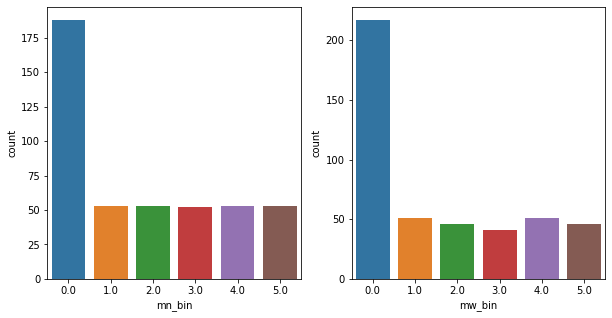

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x="mn_bin", data=df, ax=axs[0])
sns.countplot(x="mw_bin", data=df, ax=axs[1])

## Train Preprocessor Analysis Uniform (Bad!)
The uniform is problematic, as it's not scaled and most things will be in low bins. Data would need to be spread out more evenly on the X axis. As a result more bins have to be used.

In [151]:
binp = WeightBinPreprocessor(n_bins=100, strategy="uniform")

for i, row in mm.df_input.iterrows():
    binp(row, train=True)

### Quantile Results

In [153]:
df = pd.DataFrame()
binp.train = False
for i, row in mm.df_input.iterrows():
    d = binp(row)
    df_temp = pd.DataFrame([{"mn_bin": d["mn_bin"], "mw_bin": d["mw_bin"], "mn": row.Mn, "mw": row.Mw}], columns=["mn_bin", "mw_bin", "mn", "mw"])
    df = pd.concat([df, df_temp])

<AxesSubplot:xlabel='mw_bin', ylabel='count'>

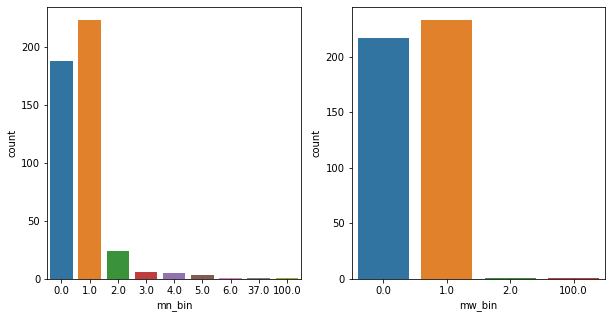

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x="mn_bin", data=df, ax=axs[0])
sns.countplot(x="mw_bin", data=df, ax=axs[1])

In [150]:
binp.mw_kbd.bin_edges_

array([array([2.21000000e+03, 4.32679950e+06, 8.65138900e+06, 1.29759785e+07,
              1.73005680e+07, 2.16251575e+07, 2.59497470e+07, 3.02743365e+07,
              3.45989260e+07, 3.89235155e+07, 4.32481050e+07, 4.75726945e+07,
              5.18972840e+07, 5.62218735e+07, 6.05464630e+07, 6.48710525e+07,
              6.91956420e+07, 7.35202315e+07, 7.78448210e+07, 8.21694105e+07,
              8.64940000e+07])                                               ],
      dtype=object)

## Train Preprocessor Analysis Kmeans
This spreads out the x axis more in a normal distribution.

In [155]:
binp = WeightBinPreprocessor(n_bins=20, strategy="kmeans")

for i, row in mm.df_input.iterrows():
    binp(row, train=True)

### Quantile Results

In [156]:
df = pd.DataFrame()
binp.train = False
for i, row in mm.df_input.iterrows():
    d = binp(row)
    df_temp = pd.DataFrame([{"mn_bin": d["mn_bin"], "mw_bin": d["mw_bin"], "mn": row.Mn, "mw": row.Mw}], columns=["mn_bin", "mw_bin", "mn", "mw"])
    df = pd.concat([df, df_temp])

<AxesSubplot:xlabel='mw_bin', ylabel='count'>

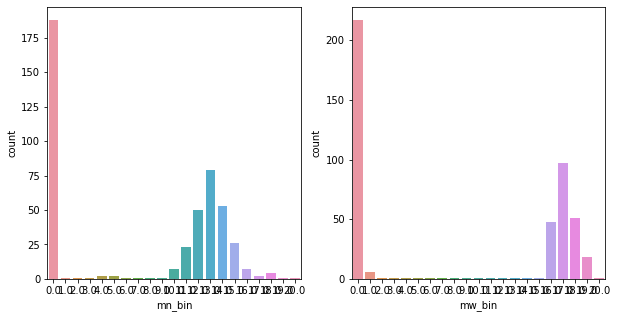

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x="mn_bin", data=df, ax=axs[0])
sns.countplot(x="mw_bin", data=df, ax=axs[1])

In [150]:
binp.mw_kbd.bin_edges_

array([array([2.21000000e+03, 4.32679950e+06, 8.65138900e+06, 1.29759785e+07,
              1.73005680e+07, 2.16251575e+07, 2.59497470e+07, 3.02743365e+07,
              3.45989260e+07, 3.89235155e+07, 4.32481050e+07, 4.75726945e+07,
              5.18972840e+07, 5.62218735e+07, 6.05464630e+07, 6.48710525e+07,
              6.91956420e+07, 7.35202315e+07, 7.78448210e+07, 8.21694105e+07,
              8.64940000e+07])                                               ],
      dtype=object)